In [ ]:
zip_path = '/content/drive/Shareddrives/IA901/dados melanoma/data/interim4/treino2.zip'
destination_folder = '/content/drive/Shareddrives/IA901/dados melanoma/data/interim4/interim5/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all files to the destination folder
    zip_ref.extractall(destination_folder)

In [6]:
from google.colab import drive
drive.mount('/content/drive')
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
batch = 32

# Caminhos das pastas contendo as imagens de treinamento e validação
#train_data_dir = "/content/drive/Shareddrives/IA901/dados melanoma/data/interim4/interim5/treino2"
#validation_data_dir = "/content/drive/Shareddrives/IA901/dados melanoma/data/data/interim/validacao"
#validation_data_dir = "/content/drive/Shareddrives/IA901/dados melanoma/data/interim4/interim5/validacao"

train_data_dir = "/content/drive/Shareddrives/IA901/dados melanoma/data/interim4/interim4/treino"
validation_data_dir = "/content/drive/Shareddrives/IA901/dados melanoma/data/data/interim/validacao"
def preprocess_image(image):
    standardized_image = preprocess_input(image)
    return standardized_image

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #width_shift_range=0.5,
    height_shift_range=0.1,
    #shear_range=0.1,
    #zoom_range=0.5,
    #brightness_range=[1.3],
    #fill_mode='nearest',
    preprocessing_function=preprocess_image
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(32, 32),
    batch_size=batch,
    shuffle=True,
    seed=42
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, train_generator.num_classes), dtype=tf.float32)
    )
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #width_shift_range=0.5,
    height_shift_range=0.1,
    #shear_range=0.1,
    #zoom_range=0.5,
    #brightness_range=[1.3],
    #fill_mode='nearest',
    preprocessing_function=preprocess_image

)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(32, 32),
    batch_size=batch,
    class_mode='categorical'
)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, validation_generator.num_classes), dtype=tf.float32)
    )
)

train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 48456 images belonging to 2 classes.
Found 8608 images belonging to 2 classes.


In [7]:
# Define a arquitetura do modelo
model = tf.keras.Sequential([
    layers.Conv2D(4, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(4, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='sigmoid')
])
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)
# Callbacks
cb_early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300)

# Define o caminho para salvar os checkpoints
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/models/checkpoints/mobilenet_oversampling_wieghs.{epoch:02d}.h5"

# Callback para salvar os checkpoints
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

callbacks_list = [checkpoint_callback, cb_early_stopper]

# Verifica se há um checkpoint existente para carregar
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_path)
if latest_checkpoint is not None:
    print("Carregando checkpoint existente:", latest_checkpoint)
    model.load_weights(latest_checkpoint)

In [8]:
# Train the model from the next epoch
history = model.fit(
    train_dataset,
    steps_per_epoch=train_generator.n // batch,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks_list,
    validation_steps=validation_generator.n // batch
)

# Save the model
# Save the model weights
model.save_weights('/content/drive/MyDrive/Colab Notebooks/models/final1aa.h5')

# Save the training history
import pickle
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)


Epoch 1/50
1514/1514 [==============================] - ETA: 0s - loss: 0.6021 - accuracy: 0.6889 - auc_2: 0.7460
Epoch 1: val_loss improved from inf to 0.53853, saving model to /content/drive/MyDrive/Colab Notebooks/models/checkpoints/mobilenet_oversampling_wieghs.01.h5
1514/1514 [==============================] - 6227s 4s/step - loss: 0.6021 - accuracy: 0.6889 - auc_2: 0.7460 - val_loss: 0.5385 - val_accuracy: 0.6413 - val_auc_2: 0.7776
Epoch 2/50
1514/1514 [==============================] - ETA: 0s - loss: 0.5170 - accuracy: 0.7504 - auc_2: 0.8231
Epoch 2: val_loss improved from 0.53853 to 0.47847, saving model to /content/drive/MyDrive/Colab Notebooks/models/checkpoints/mobilenet_oversampling_wieghs.02.h5
1514/1514 [==============================] - 308s 203ms/step - loss: 0.5170 - accuracy: 0.7504 - auc_2: 0.8231 - val_loss: 0.4785 - val_accuracy: 0.7110 - val_auc_2: 0.8330
Epoch 3/50
1514/1514 [==============================] - ETA: 0s - loss: 0.4841 - accuracy: 0.7716 - auc_2: 0

NameError: ignored

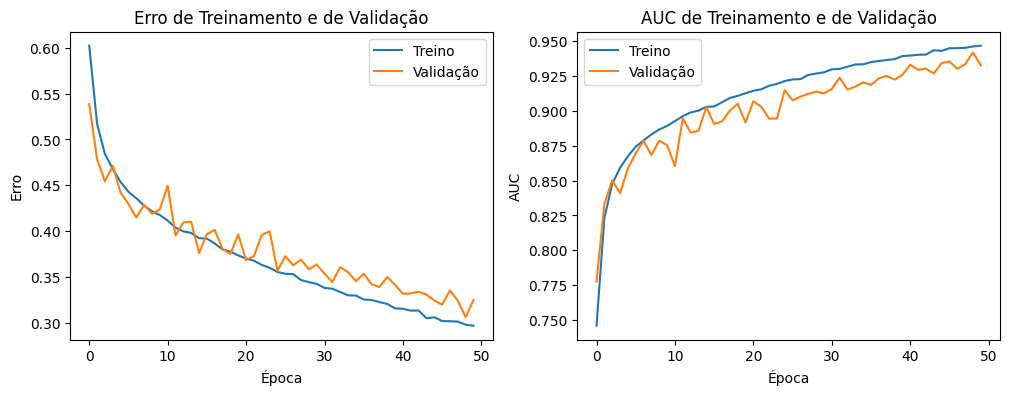

In [10]:
# Plotting AUC and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.xlabel('Época')
plt.ylabel('Erro')
plt.title('Erro de Treinamento e de Validação')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc_2'], label='Treino')
plt.plot(history.history['val_auc_2'], label='Validação')
plt.xlabel('Época')
plt.ylabel('AUC')
plt.title('AUC de Treinamento e de Validação')
plt.legend()
plt.show()

In [12]:
# Evaluation and Metrics
from sklearn.metrics import confusion_matrix
predictions = model.predict(validation_generator)
y_true = validation_generator.classes
y_pred = predictions.argmax(axis=1)

confusion_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

false_positive_rate = confusion_mat[0, 1] / (confusion_mat[0, 1] + confusion_mat[0, 0])
print("False Positive Rate:", false_positive_rate)

269/269 [==============================] - 45s 169ms/step
Confusion Matrix:
[[6934 1527]
 [ 119   28]]
False Positive Rate: 0.1804751211440728


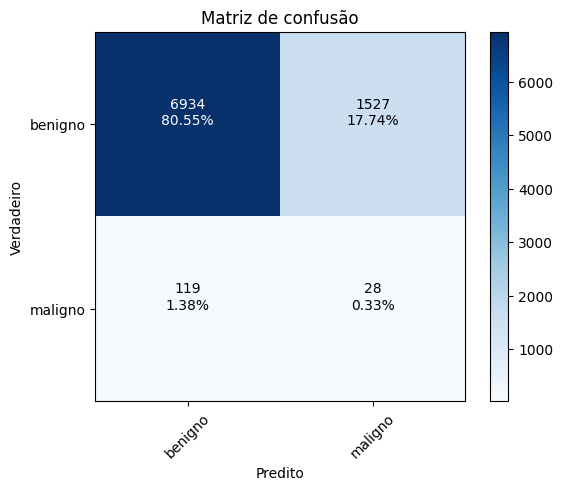

In [13]:
# Obtém as classes reais e as classes previstas
y_true = validation_generator.classes
y_pred = predictions.argmax(axis=1)

# Calcula a matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with total numbers
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Obtém os rótulos das classes
class_names = validation_generator.class_indices
class_names = list(class_names.keys())

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Calculate the total numbers in each group
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]

# Add the total numbers to the plot
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(cm.shape[0], cm.shape[1])

# Show the total numbers in each group
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, labels[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()